In [68]:
import pandas as pd
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import spacy
from spacy.cli.download import download

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
download(model="en_core_web_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [69]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
import graphviz 
import json
import time
import gc
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from collections import Counter
from sklearn import model_selection
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import networkx as nx
import warnings
%matplotlib inline
init_notebook_mode(connected=True) 
warnings.filterwarnings("ignore")
notebookstart= time.time()

In [70]:
cuisine_df = pd.read_csv("C:/Prerna Tulsiani/COEP/Sem6/Data Science Project/Final Project/cuisines.csv")

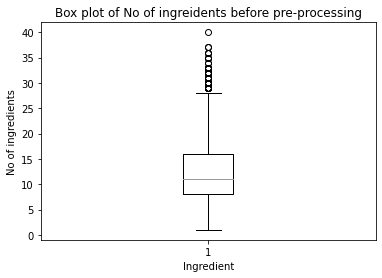

In [71]:
no_of_ing = []

ing_list = cuisine_df['Ingredients']

for iterator in range(len(cuisine_df.index)):
    if(iterator in cuisine_df.index):
        ingredients = str(ing_list[iterator])
        no_of_ing.append(len(ingredients.split(", ")))

# Create a box plot
fig, ax = plt.subplots()
ax.boxplot(no_of_ing)

# Add labels and title
ax.set_title('Box plot of No of ingreidents before pre-processing')
ax.set_xlabel('Ingredient')
ax.set_ylabel('No of ingredients')

# Show the plot
plt.show()

In [72]:
from nltk.stem import WordNetLemmatizer
import re
wnl = WordNetLemmatizer()

def remove_recipe_with_no_ingredients(data):
    data = data.dropna(subset=['Ingredients'])
    return data

def preprocess_data(data):
    
    # this function will make a string of ingredients out of the given list
    def process_ingredient_string(x):
        
        x = ", ".join([wnl.lemmatize(ing) for ing in x.split(", ")])
        return x
    
    def lemmatize(x):
        for word in re.findall(r"[a-z]+", x):
            x = x.replace(word, wnl.lemmatize(word, 'n') if 's' in word[-3:] else word)
        return x
        
    def removing_special_characters(x):
        
        # remove anything inside paranthesis
        x = re.sub(r"\([^\)]+\)", '', x)
        
        # remove anything containing a digit
        x = re.sub(r"\S*\d\S*", '', x)
        
        # make everything lowercase
        x = x.lower()
        
        # lemmatize all ingredients in the string
        x = lemmatize(x)
        
        # remove non-word characters except for , and -
        x = ' '.join(re.findall(r"[-,''\w]+", x))
                     
        # clean excess whitespace
        x = re.sub(r"\s+", ' ', x).strip()
        
        return x
    
    data['Ingredients'] = data['Ingredients'].apply(process_ingredient_string)
    data['Ingredients'] = data['Ingredients'].apply(removing_special_characters)
    
    return data

In [73]:
# First removing rows where ingredients are not present
cuisine_df = remove_recipe_with_no_ingredients(cuisine_df)

# Preprocessing data
cuisine_df = preprocess_data(cuisine_df)

Text(0.5, 1.0, 'Top 50 Ingredients')

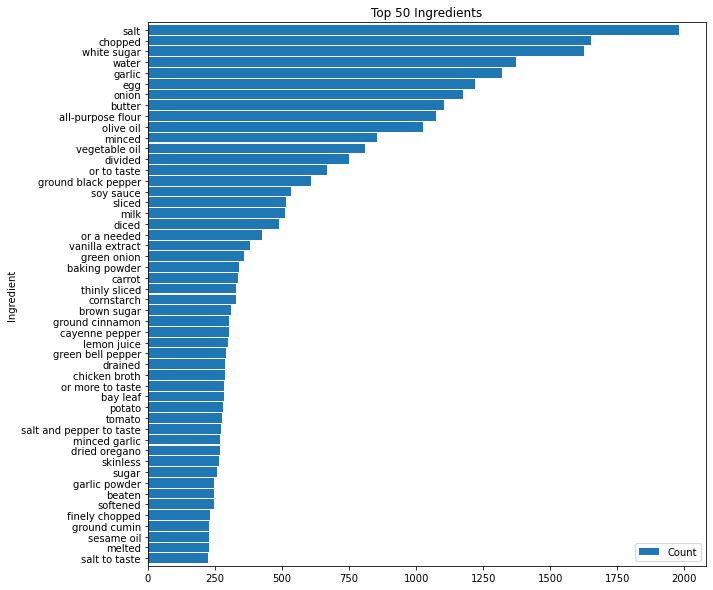

In [74]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(tokenizer=lambda x: [i.strip() for i in x.split(', ')], lowercase=False)
counts = vec.fit_transform(cuisine_df['Ingredients']) 
count=dict(zip(vec.get_feature_names(), counts.sum(axis=0).tolist()[0]))
count=pd.DataFrame(list(count.items()),columns=['Ingredient','Count'])
count.set_index('Ingredient').sort_values('Count',ascending=False)[:50].plot.barh(width=0.9)
plt.gcf().set_size_inches(10,10)
plt.gca().invert_yaxis()
plt.title('Top 50 Ingredients')

# from here we will remove chopped, all-purpose, divided, or to taste, sliced, or a needed, finely chopped, minced, thinly sliced, melted, to taste, skinless

In [75]:
# removing unnecessary verbs and words from the ingredients
# using POS(Part of Speech) tagging to remove non-ingredient words from a list of ingredients using NLTK library

cuisine_list = cuisine_df['Cuisine']
ingredient_list = cuisine_df['Ingredients']

# set of stop words to filter out
stop_words = set(stopwords.words('english'))

# not-needed terms
not_needed = ['chopped', 'all-purpose', 'divided', 'or', 'to', 'taste', 'sliced', 'a', 'needed', 'finely', 'chopped', 'minced', 'thinly', 'sliced', 'melted', 'to', 'taste', 'skinless']

# define a set of POS tags to keep
keep_tags = set(['NN', 'NNS', 'NNP', 'NNPS'])

cleaned_ingredients = []

for iterator in range(len(cuisine_df.index)):
    if(iterator in cuisine_df.index):
        ingredients = ingredient_list[iterator]
        cleaned_tokens = []
        for ing in ingredients.split(", "):
            individual_cleaned_token = []
            for i in ing.split():
                tokens = word_tokenize(i.lower())
                tagged_tokens = nltk.pos_tag(tokens)
                for token, tag in tagged_tokens:
                    if tag in keep_tags and token not in stop_words and token not in not_needed:
                        individual_cleaned_token.append(token)
            if(individual_cleaned_token):
                cleaned_tokens.append(" ".join(individual_cleaned_token))
        new_ing_list = ", ".join(cleaned_tokens)
        cuisine_df.loc[iterator, 'Ingredients'] = new_ing_list
        
cuisine_df.to_csv('test_data.csv', index=False)

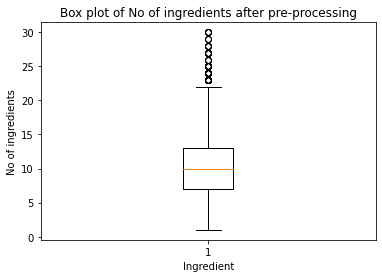

In [76]:
no_of_ing = []

ing_list = cuisine_df['Ingredients']

for iterator in range(len(cuisine_df.index)):
    if(iterator in cuisine_df.index):
        ingredients = str(ing_list[iterator])
        no_of_ing.append(len(ingredients.split(", ")))

# Create a box plot
fig, ax = plt.subplots()
ax.boxplot(no_of_ing)

# Add labels and title
ax.set_title('Box plot of No of ingredients after pre-processing')
ax.set_xlabel('Ingredient')
ax.set_ylabel('No of ingredients')

# Show the plot
plt.show()

In [77]:
cuisine_df.head(10)

,Cuisine,Dish Name,Ingredients,Calories,Carbs,Fat,Protein
0,Amish and Mennonite,Baked Oatmeal,"oat, brown sugar, ground cinnamon, baking powd...",393.0,59g,15g,7g
1,Amish and Mennonite,Amish White Bread,"warm water, sugar, dry yeast, vegetable oil, s...",168.0,31g,3g,4g
2,Amish and Mennonite,Cheesy Amish Breakfast Casserole,"bacon, sweet onion, egg, beaten, frozen hash b...",314.0,12g,23g,22g
3,Amish and Mennonite,Pennsylvania Dutch Pickled Beets and Eggs,"egg, beet, juice, onion, sugar, cider vinegar,...",252.0,45g,5g,7g
4,Amish and Mennonite,Amish Macaroni Salad,"elbow macaroni, egg, onion, celery, bell peppe...",532.0,66g,25g,9g
5,Amish and Mennonite,Amish Friendship Bread Starter,"dry yeast, warm water, flour, sugar, milk",34.0,8g,0g,1g
6,Amish and Mennonite,My Amish Friend's Caramel Corn,"plain popped popcorn, dry peanut, brown sugar,...",238.0,22g,16g,3g
7,Amish and Mennonite,Pennsylvania Dutch Corn Pie,"potato, kernel corn, cream-style corn, egg, sa...",417.0,52g,21g,9g
8,Amish and Mennonite,Amish Peanut Butter,"light corn syrup, peanut butter, smooth, marsh...",74.0,12g,3g,1g
9,Amish and Mennonite,Amish Meatloaf,"ground beef, cracker, onion, egg, ketchup, bro...",464.0,46g,21g,24g


In [78]:
# Most common ingredients in each cuisine

cuisine_dict = dict()

for iterator in range(len(cuisine_df.index)):
    if(iterator in cuisine_df.index):
        cuisine = cuisine_list[iterator]
        ingredients = ingredient_list[iterator]
        if(cuisine not in cuisine_dict):
            cuisine_dict[cuisine] = dict()
        for ing in ingredients.split():
            if ing not in cuisine_dict[cuisine]:
                cuisine_dict[cuisine][ing] = 1
            else:
                cuisine_dict[cuisine][ing] += 1
            

In [79]:
max_ing = 0
min_ing = 10000000
list_of_ing_len = []

for iterator in range(len(cuisine_df.index)):
    if(iterator in cuisine_df.index):
        temp_l = cuisine_df['Ingredients'][iterator].split(", ")
        list_of_ing_len.append(len(temp_l))
        if(len(temp_l) <= min_ing):
            min_ing = len(temp_l)
        if(len(temp_l) >= max_ing):
            max_ing = len(temp_l)
            
print(min_ing, max_ing)

1 30


Text(0.5, 1.0, 'Ingredients in a Dish Distribution')

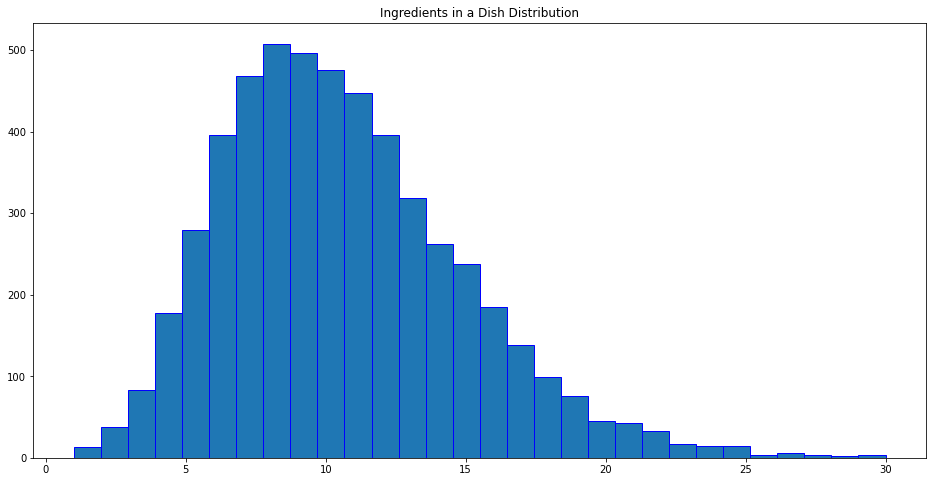

In [80]:
plt.hist(list_of_ing_len,bins = max_ing,edgecolor='b')
plt.gcf().set_size_inches(16,8)
plt.title('Ingredients in a Dish Distribution')

Text(0.5, 1.0, 'Cuisine Distribution')

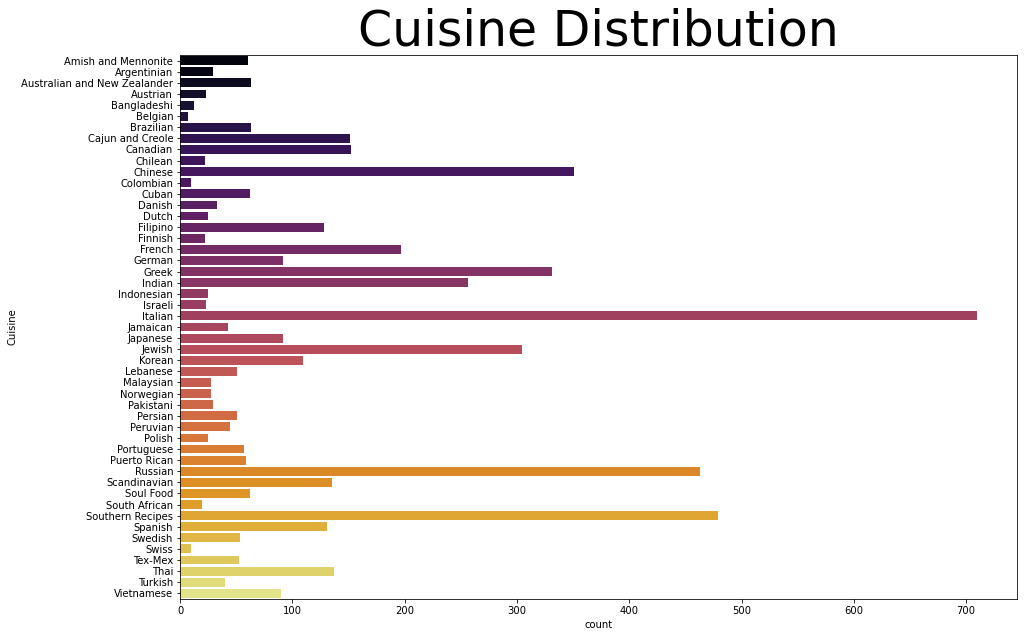

In [81]:
sns.countplot(y='Cuisine', data=cuisine_df,palette=sns.color_palette('inferno',50))
plt.gcf().set_size_inches(15,10)
plt.title('Cuisine Distribution',size=len(cuisine_df['Cuisine'].value_counts()))

Text(0.5, 1.0, 'Top 50 Ingredients')

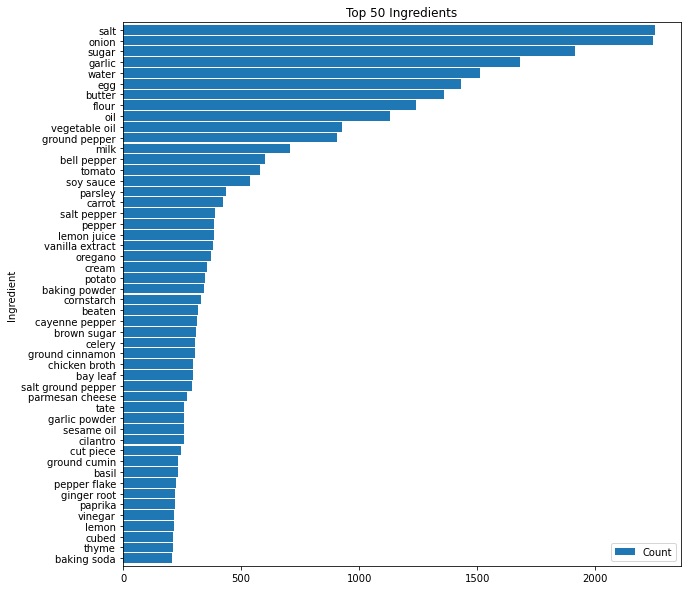

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(tokenizer=lambda x: [i.strip() for i in x.split(', ')], lowercase=False)
counts = vec.fit_transform(cuisine_df['Ingredients']) 
count=dict(zip(vec.get_feature_names(), counts.sum(axis=0).tolist()[0]))
count=pd.DataFrame(list(count.items()),columns=['Ingredient','Count'])
count.set_index('Ingredient').sort_values('Count',ascending=False)[:50].plot.barh(width=0.9)
plt.gcf().set_size_inches(10,10)
plt.gca().invert_yaxis()
plt.title('Top 50 Ingredients')

In [83]:
# Finding all possible ingredient items present to build binary ingredient table

ingreList = []
for index, row in cuisine_df.iterrows():
    
    ingre = row['Ingredients']
    for i in ingre.split(", "):
        if i not in ingreList:
            ingreList.append(i)

In [84]:
def binary(ingre_list):
    
    binaryList = []
    
    for item in ingreList:
        if item in ingre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

cuisine_df['Bin Ingredients'] = cuisine_df['Ingredients'].apply(lambda x: binary(x))

In [85]:
from scipy import spatial

def Similarity(Id1, Id2):
    
    A = cuisine_df['Bin Ingredients'][Id1]
    B = cuisine_df['Bin Ingredients'][Id2]
    distance=spatial.distance.cosine(A,B)
    
    return distance, Id2

In [86]:
#Dishes similar to Dish No 1
food=[]
for i in cuisine_df.index:
    food.append(Similarity(1,i))
common_ingredients=sorted(food,key=lambda x: x[0])[1:10]
indexes = []
for i in range(len(common_ingredients)):
    indexes.append(common_ingredients[i][1])
cuisine_df.iloc[indexes]

,Cuisine,Dish Name,Ingredients,Calories,Carbs,Fat,Protein,Bin Ingredients
3126,Jewish,Matzah,"flour, flour, water, kosher salt, oil",63.0,12g,1g,2g,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2569,Italian,Tortellini Salad,"cheese tortellini, artichoke heart, mozzarella...",415.0,30g,26g,17g,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2870,Jamaican,Instant Pot® Jamaican Rice and Beans,"vegetable oil, boneless chicken breast, cut pi...",454.0,64g,13g,22g,"[0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, ..."
2932,Japanese,Tonkatsu,"boneless pork chop, salt ground pepper tate, o...",290.0,20g,17g,17g,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3087,Jewish,Rugelach,"flour, salt, butter, cream cheese, sour cream,...",101.0,8g,7g,1g,"[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
2598,Italian,Insalata Tricolore,"ripe beefsteak tomato, cut slice, ripe avocado...",391.0,15g,35g,8g,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5128,Vietnamese,Vietnamese Fresh Spring Rolls,"rice vermicelli, rice wrapper, shrimp, thai ba...",NaN,NaN,4.6445,18.5009,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1519,German,Sauerbraten IV,"wine vinegar, dry wine, onion, carrot, bay lea...",715.0,21g,48g,46g,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, ..."
2591,Italian,Macaroni Salad for a Crowd,"macaroni, egg, onion, dill pickle relish, mayo...",472.0,48g,23g,18g,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [87]:
# Top Bigrams By Cuisines
import nltk
from collections import Counter

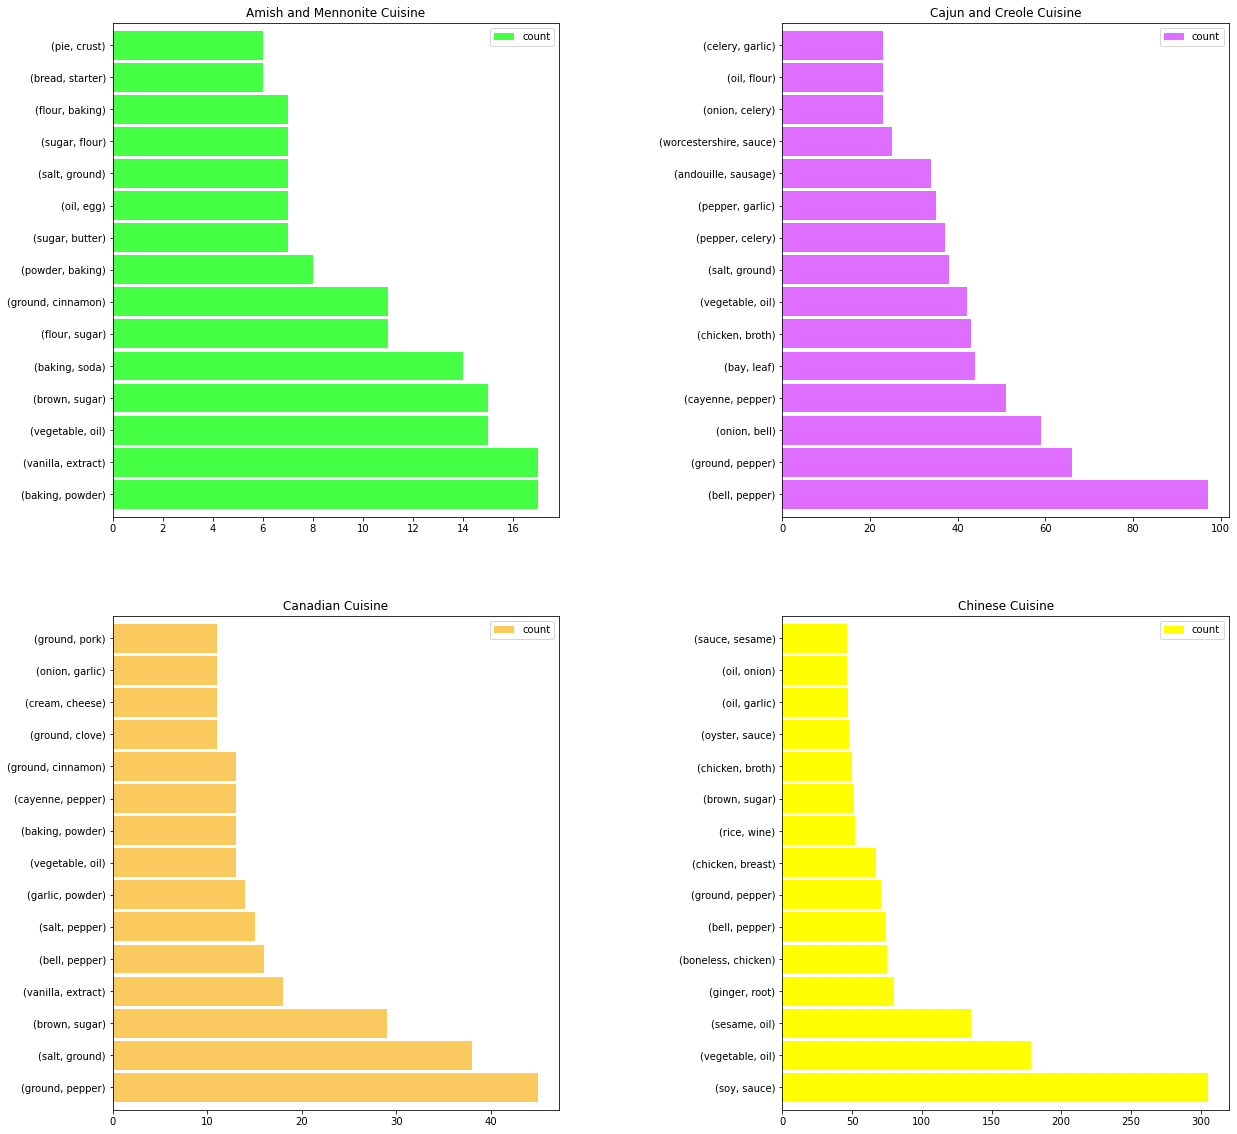

In [88]:
cuisine_df['for ngrams']=cuisine_df['Ingredients'].str.replace(', ',' ')
f,ax=plt.subplots(2,2,figsize=(20,20))

def ingre_cusine(cuisine):
    frame=cuisine_df[cuisine_df['Cuisine']==cuisine]
    common=list(nltk.bigrams(nltk.word_tokenize(" ".join(frame['for ngrams']))))
    return pd.DataFrame(Counter(common),index=['count']).T.sort_values('count',ascending=False)[:15]

ingre_cusine('Amish and Mennonite').plot.barh(ax=ax[0,0],width=0.9,color='#45ff45')
ax[0,0].set_title('Amish and Mennonite Cuisine')

ingre_cusine('Cajun and Creole').plot.barh(ax=ax[0,1],width=0.9,color='#df6dfd')
ax[0,1].set_title('Cajun and Creole Cuisine')

ingre_cusine('Canadian').plot.barh(ax=ax[1,0],width=0.9,color='#fbca5f')
ax[1,0].set_title('Canadian Cuisine')

ingre_cusine('Chinese').plot.barh(ax=ax[1,1],width=0.9,color='#ffff00')
ax[1,1].set_title('Chinese Cuisine')
plt.subplots_adjust(wspace=0.5)

In [89]:
test_df = pd.read_csv("C:/Prerna Tulsiani/COEP/Sem6/Data Science Project/Final Project/test_data.csv")
test_df['Ingredients']

0       oat, brown sugar, ground cinnamon, baking powd...
1       warm water, sugar, dry yeast, vegetable oil, s...
2       bacon, sweet onion, egg, beaten, frozen hash b...
3       egg, beet, juice, onion, sugar, cider vinegar,...
4       elbow macaroni, egg, onion, celery, bell peppe...
                              ...                        
5431    white bread, half, chicken, egg, salt, black p...
5432    mayonnaise, egg, garlic clove, cream, salt, pi...
5433    flour, sugar, salt, margarine, cake yeast, egg...
5434          salt, flour, butter, vanilla, sugar, walnut
5435    egg white, cream tartar, white vinegar, superf...
Name: Ingredients, Length: 5436, dtype: object

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(binary=True).fit(cuisine_df['Ingredients'].values)
X_train_vectorized = vect.transform(cuisine_df['Ingredients'].values)
X_train_vectorized = X_train_vectorized.astype('float')

Result_transformed = vect.transform(test_df['Ingredients'].values)
Result_transformed = Result_transformed.astype('float')

In [91]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_transformed = encoder.fit_transform(cuisine_df.Cuisine)

In [92]:
# Logistic Regression

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_vectorized, y_transformed , random_state = 0)

from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression(C=10,dual=False)
clf1.fit(X_train , y_train)
clf1.score(X_test, y_test)

0.5467255334805003

In [93]:
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
vclf=VotingClassifier(estimators=[('clf1',LogisticRegression(C=10,dual=False)),('clf2',SVC(C=100,gamma=1,kernel='rbf',probability=True))],voting='soft',weights=[1,2])
vclf.fit(X_train , y_train)
vclf.score(X_test, y_test)

0.5695364238410596

In [94]:
y_predicted = vclf.predict(Result_transformed)
y_predicted_final = encoder.inverse_transform(y_predicted)
predictions = pd.DataFrame({'cuisine' : y_predicted_final})
predictions = predictions[['cuisine']]
predictions.to_csv('submit.csv', index = False)